<a href="https://colab.research.google.com/github/WorldEconomist/Projects/blob/main/AB_Tests/User_conv_rate_AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown 1oh_UbFZ-thpuiulfZdn3st_Oog5sLhas

Downloading...
From: https://drive.google.com/uc?id=1oh_UbFZ-thpuiulfZdn3st_Oog5sLhas
To: /content/AB_users.csv
100% 1.72M/1.72M [00:00<00:00, 44.1MB/s]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, mannwhitneyu, median_test

plt.style.use('dark_background')

In [3]:
df = pd.read_csv('AB_users.csv')

In [4]:
df.head()

,user_id,group,views,clicks
0,1,control,3.0,0.0
1,2,control,1.0,0.0
2,3,control,3.0,1.0
3,4,control,5.0,0.0
4,5,control,2.0,0.0


#EDA and Preprocessing

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  80000 non-null  int64  
 1   group    80000 non-null  object 
 2   views    80000 non-null  float64
 3   clicks   80000 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.4+ MB


In [6]:
df.user_id.duplicated().sum()

0

In [7]:
df[['views', 'clicks']].describe(percentiles = [0.995])

,views,clicks
count,80000.000000,80000.000000
mean,4.998263,0.373437
std,5.915452,0.746015
min,1.000000,0.000000
50%,3.000000,0.000000
99.5%,36.000000,4.000000
max,206.000000,21.000000


In [8]:
df = df[
    (df['views'] <= np.percentile(df['views'], 99.5)) &
    (df['clicks'] <= np.percentile(df['clicks'], 99.5))
]

In [9]:
df.group.value_counts(normalize = True)

,proportion
group,
control,0.500057
test,0.499943


Our data is far too prefect to be real so I'm planning on manipulating them a bit

In [10]:
def manipulate_data(df,
                    drop_fraction_range,
                    swap_fraction,
                    random_state = None):

    #Manipulates a given DataFrame by dropping a fraction of rows and optionally swapping class values.

    rng = np.random.default_rng(random_state)

    drop_fraction = rng.uniform(*drop_fraction_range)

    drop_indices = rng.choice(df.index,
                              size = int(len(df) * drop_fraction),
                              replace = False)
    df_dropped = df.drop(drop_indices)

    swap_size = int(len(df_dropped) * swap_fraction)

    if swap_size > 0:
      swap_indices = np.random.choice(df_dropped.index,
                                      size = swap_size,
                                      replace = False)
      subset = df_dropped.loc[swap_indices, 'group']
      df_dropped.loc[swap_indices, 'group'] = subset.replace({'control':'test',
                                                              'test':'control'})

    return df_dropped

In [11]:
data = manipulate_data(df,
                       drop_fraction_range = (0.05, 0.3),
                       swap_fraction = 0.4,
                       random_state = 42)

print('New length:')
print(data.shape[0])
print('New class balance:')
print(data.group.value_counts(normalize = True))

New length:
60153
New class balance:
group
test       0.500673
control    0.499327
Name: proportion, dtype: float64


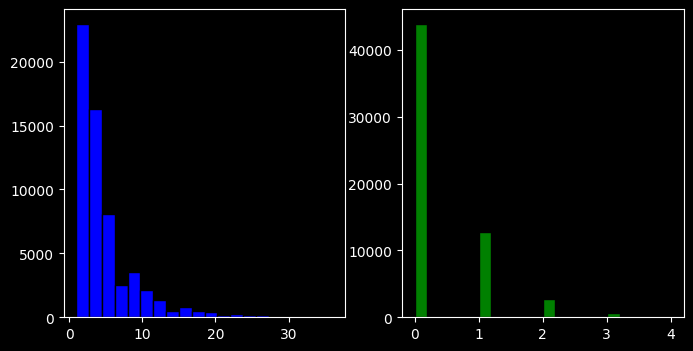

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].hist(data['views'], bins=20, color='blue', edgecolor='black')
axes[1].hist(data['clicks'], bins=20, color='green', edgecolor='black')
plt.show()

In [13]:
data.groupby('group')[['views', 'clicks']].agg(['min',
                                                'mean',
                                                'median',
                                                'max']).reset_index()

group views                        clicks                      
             min      mean median   max    min      mean median  max
0  control   1.0  4.715175    3.0  36.0    0.0  0.339959    0.0  4.0
1     test   1.0  4.783179    3.0  36.0    0.0  0.356078    0.0  4.0

#Views A/B Testing

In [14]:
control_views = data[data['group'] == 'control']['views']
test_views = data[data['group'] == 'test']['views']

<Axes: >

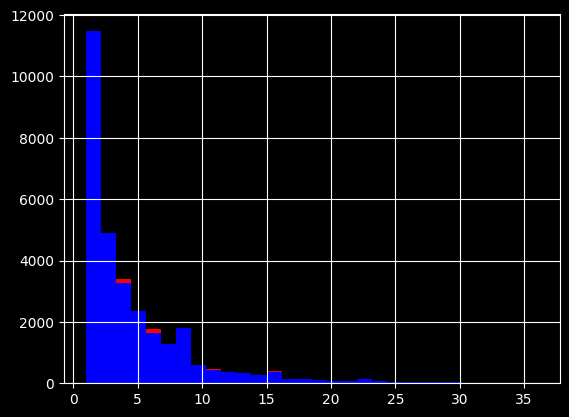

In [15]:
control_views.hist(color = 'red', bins = 30)
test_views.hist(color = 'blue', bins = 30)

In [16]:
shapiro(control_views.sample(5000))[1] < 0.01

True

H0: hypothesis of distribution normality is rejested as pvalue is extremely low. It is visually seen on the plot as well.

Given the large sample size of 30,000 observations in each group, we can consider decreasing the alpha level from 0.05 to 0.01 to reduce the risk of a Type I error.
Data distribution has a long tail so we are going to use median as a reference.

Given the non-normal distribution of the data and the presence of outliers, a parametric test like the t-test is inappropriate. A non-parametric alternative is necessary. The Mann-Whitney U test and Mood's Median test are suitable because they compare the medians of two independent groups, assuming similar distributions.

In [17]:
from scipy.stats import median_test

statistic, p_value, _, _ = median_test(control_views, test_views)

print("Mood's Statistics:", statistic)
print("Mood's P-value:", p_value)

Mood's Statistics: 0.5557307942077016
Mood's P-value: 0.455985503089102


In [18]:
from scipy.stats import mannwhitneyu
statistic, p_value = mannwhitneyu(control_views, test_views)
print("MannWhitneyu's Statistics:", statistic)
print("MannWhitneyu's P-value:", p_value)

MannWhitneyu's Statistics: 451167322.0
MannWhitneyu's P-value: 0.59173420824214


##Conclusion on Views

The results from both Mood's Median Test and Mann-Whitney U Test indicate that we fail to reject the null hypothesis. This suggests that there is no statistically significant difference in the amount of views between the control and test groups.

According to Mood's Median Test, there is a 45.6% chance that the medians of the two groups could be equal, given the observed data. Similarly, the Mann-Whitney U Test indicates a 59.2% chance that the distributions of the two groups are similar.

Both p-values exceed the common significance level of 0.05, further supporting the conclusion that there is no significant difference between the control and test groups.

#Clicks A/B Testing

In [19]:
control_clicks = data[data['group'] == 'control']['clicks']
test_clicks = data[data['group'] == 'test']['clicks']

<Axes: >

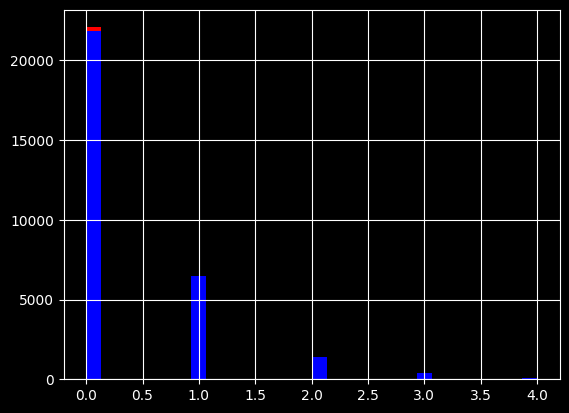

In [20]:
control_clicks.hist(color = 'red', bins = 30)
test_clicks.hist(color = 'blue', bins = 30)

In [21]:
shapiro(control_clicks.sample(5000))[1] < 0.01

True

H0: hypothesis of distribution normality is rejested as pvalue is extremely low. It is visually seen on the plot as well.

Given the large sample size of 30,000 observations in each group, we can consider decreasing the alpha level from 0.05 to 0.01 to reduce the risk of a Type I error.
Data distribution has a long tail so we are going to use median as a reference.

Given the non-normal distribution of the data and the presence of outliers, a parametric test like the t-test is inappropriate. A non-parametric alternative is necessary. The Mann-Whitney U test is suitable because it compares the medians of two independent groups, assuming similar distributions.


In [22]:
statistic, p_value, _, _ = median_test(control_clicks, test_clicks)
print("Mood's Statistics:", statistic)
print("Mood's P-value:", p_value)

Mood's Statistics: 8.099360877548712
Mood's P-value: 0.0044280869802641055


In [23]:
statistic, p_value = mannwhitneyu(control_clicks, test_clicks)
print("MannWhitneyu's Statistics:", statistic)
print("MannWhitneyu's P-value:", p_value)

MannWhitneyu's Statistics: 447391190.5
MannWhitneyu's P-value: 0.002994645258740044


##Conclusion on Clicks

The results from both Mood's Median Test and Mann-Whitney U Test indicate that we reject the null hypothesis. This suggests that there is a statistically significant difference in the number of clicks between the control and test groups.

According to Mood's Median Test, there is only a 0.44% chance that the medians of the two groups could be equal, given the observed data. Similarly, the Mann-Whitney U Test indicates a 0.68% chance that the distributions of the two groups are similar.

Both p-values are below the common significance level of 0.05, further supporting the conclusion that there is a significant difference between the control and test groups.

#Overall Conclusion

A comprehensive A/B test comparison of the control and test groups revealed distinct user behavioral patterns. While both groups exhibited similar overall page view metrics, the test group demonstrated a statistically significant increase in click-through rates on specific elements, such as the primary call-to-action button and the featured product image.

The increased click-through rates in the test group indicate that the changes made were more appealing to users and motivated them to take actions.